In [1]:
#!pip install torchvision

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
torch.__version__, torchvision.__version__

('1.7.0', '0.8.1')

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [7]:
batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


 ship      cat     bird    truck    airplane    airplane     frog      dog


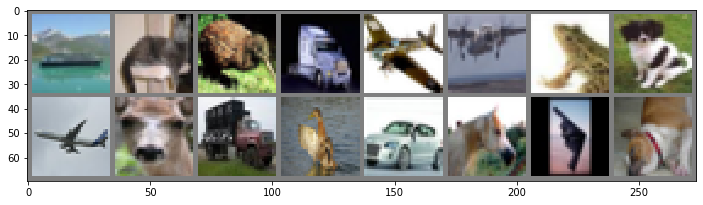

airplane     deer    truck     bird    automobile    horse    airplane      dog


In [8]:
def imshow(img):
    fig, ax = plt.subplots(figsize=(12, 4))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
print('    '.join('%5s' % trainset.classes[labels[j]] for j in range(0,int(batch_size/2))))
imshow(torchvision.utils.make_grid(images))
print('    '.join('%5s' % trainset.classes[labels[j]] for j in range(int(batch_size/2),batch_size)))

In [ ]:
images.shape

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, len(trainset.classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [10]:
sample = next(iter(trainloader))

In [11]:
net(images.to(device)).shape

torch.Size([16, 10])

In [12]:
print(images.shape)
x = net.conv1(images.to(device))
print(x.shape)

torch.Size([16, 3, 32, 32])
torch.Size([16, 6, 28, 28])


In [13]:
x = F.relu(x)
print(x.shape)

torch.Size([16, 6, 28, 28])


In [14]:
x = net.pool(x)
print(x.shape)

torch.Size([16, 6, 14, 14])


In [15]:
x=net.pool(F.relu(net.conv2(x)))
print(x.shape)

torch.Size([16, 16, 5, 5])


In [16]:
x = x.view(-1, 16 * 5 * 5)
print(x.shape)

torch.Size([16, 400])


In [17]:
x = F.relu(net.fc1(x))
print(x.shape)

torch.Size([16, 512])


In [18]:
x = F.relu(net.fc2(x))
print(x.shape)

torch.Size([16, 256])


In [19]:
x = net.fc3(x)
print(x.shape)

torch.Size([16, 10])


In [20]:
def train_model(epochs, model, model_name = "model", init_lr = 0.01, use_scheduler = False):
    from torch.optim.lr_scheduler import ReduceLROnPlateau
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9)
    if use_scheduler:
        print("Training using LR Scheduler")
        scheduler = ReduceLROnPlateau(optimizer, 'min')
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print("[{}, {}] loss: {:.10f} - lr {:.10f} ".format(epoch + 1, i + 1, running_loss / 2000, optimizer.param_groups[0]['lr'] ))
                if use_scheduler:
                    scheduler.step(running_loss)
                
                running_loss = 0.0
        ## save checkpoint
        if epoch % 100 == 0:
            _save_checkpoint(model, epoch, model_name)
    return "Train finished"

In [21]:
def _save_checkpoint(model, epoch, model_name):
    model_name = "trained_models/{}_{}.pt".format(model_name, epoch)
    torch.save(model.state_dict(), model_name)
    return "Checkpoint saved: {}".format(model_name)

In [22]:
def calculate_accuracy(model, loader):
    total = 0
    correct = 0
    for i, (x, label) in enumerate(loader):
        logits = model(x.to(device))
        conf, preds = logits.topk(1)
        correct += (label.to(device) == preds.squeeze(1)).sum()
        total +=label.size(0)
    return (100*correct/total).item()

In [ ]:
#train_model(2, net, use_scheduler = True)

In [23]:
calculate_accuracy(net, testloader)

10.0

In [ ]:
!ls -lah trained_models/

## LeNet

In [24]:
 class LeNet5(nn.Module):
    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits

In [25]:
NUM_CLASSES = len(trainset.classes)
modelLeNet = LeNet5(NUM_CLASSES)
modelLeNet.to(device)
modelLeNet

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
#!rm trained_models/LeNet_tiny_*
!ls -lah trained_models

In [ ]:
train_model(1500, modelLeNet,  model_name = "LeNet_tiny__", init_lr = 0.01, use_scheduler = True)

In [ ]:
calculate_accuracy(modelLeNet, testloader)

In [26]:
!ls -lah trained_models/

total 317M
drwxrwxr-x  2 roberto roberto 4.0K Nov  2 15:18 .
drwxrwxr-x 12 roberto roberto 4.0K Nov  2 18:21 ..
-rw-rw-r--  1 roberto roberto 246K Nov  1 12:07 LeNet_tiny__0.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 14:07 LeNet_tiny__1000.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 12:19 LeNet_tiny__100.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 14:19 LeNet_tiny__1100.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 14:31 LeNet_tiny__1200.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 14:44 LeNet_tiny__1300.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 14:56 LeNet_tiny__1400.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 12:31 LeNet_tiny__200.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 12:43 LeNet_tiny__300.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 12:55 LeNet_tiny__400.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 13:07 LeNet_tiny__500.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 13:19 LeNet_tiny__600.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 13:31 LeNet_tiny__700.pt
-rw-rw-r--  1 

In [ ]:
epoch_load = 100
model_1 = LeNet5(NUM_CLASSES)
model_1.to(device)
model_1.load_state_dict(torch.load("trained_models/LeNet_tiny__{}.pt".format(epoch_load)))
calculate_accuracy(model_1, testloader)

In [ ]:
for l in ['100','200','300','400','500','600','700','800','900']:
    model_1 = LeNet5(NUM_CLASSES)
    model_1.to(device)
    model_1.load_state_dict(torch.load("trained_models/LeNet_tiny__{}.pt".format(l)))
    print(calculate_accuracy(model_1, testloader))

In [30]:
model_lenet5 = LeNet5(NUM_CLASSES)
model_lenet5.to(device)
model_lenet5.load_state_dict(torch.load("trained_models/LeNet_tiny__1400.pt"))
calculate_accuracy(model_lenet5, testloader)

49.88999938964844

## Resnet

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

In [32]:
def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
model_resnet100 = ResNet(BasicBlock, [18, 18, 18])
model_resnet100.to(device)

In [ ]:
sample = next(iter(trainloader))
model_resnet100(sample[0].to(device))

In [ ]:
#!rm trained_models/resnet_110__0.pt
!ls -lah trained_models/

In [33]:
#train_model(300, model_resnet100,  model_name = "resnet_2_110", init_lr = 0.01, use_scheduler = True)

In [34]:
!ls -lah trained_models/

total 317M
drwxrwxr-x  2 roberto roberto 4.0K Nov  2 15:18 .
drwxrwxr-x 12 roberto roberto 4.0K Nov  2 18:21 ..
-rw-rw-r--  1 roberto roberto 246K Nov  1 12:07 LeNet_tiny__0.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 14:07 LeNet_tiny__1000.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 12:19 LeNet_tiny__100.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 14:19 LeNet_tiny__1100.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 14:31 LeNet_tiny__1200.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 14:44 LeNet_tiny__1300.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 14:56 LeNet_tiny__1400.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 12:31 LeNet_tiny__200.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 12:43 LeNet_tiny__300.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 12:55 LeNet_tiny__400.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 13:07 LeNet_tiny__500.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 13:19 LeNet_tiny__600.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 13:31 LeNet_tiny__700.pt
-rw-rw-r--  1 

In [35]:
model_1 = ResNet(BasicBlock, [18, 18, 18])
model_1.to(device)
model_1.load_state_dict(torch.load("trained_models/resnet_2_110_200.pt"))
calculate_accuracy(model_1, testloader)

83.95999908447266

## Wide RestNet

In [36]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform_(m.weight, gain=np.sqrt(2))
        init.constant_(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

class wide_basic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(wide_basic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Wide_ResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate, num_classes):
        super(Wide_ResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (depth-4)/6
        k = widen_factor

        print('| Wide-Resnet %dx%d' %(depth, k))
        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0])
        self.layer1 = self._wide_layer(wide_basic, nStages[1], n, dropout_rate, stride=1)
        self.layer2 = self._wide_layer(wide_basic, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(wide_basic, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(int(num_blocks)-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

In [39]:
wideresnet=Wide_ResNet(28, 10, 0.3, 10)
wideresnet.to(device)

| Wide-Resnet 28x10


Wide_ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): wide_basic(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): wide_basic(
      (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2

In [40]:
wideresnet(sample[0].to(device))

tensor([[-0.1534, -0.2219,  0.0666,  0.3042,  0.3883, -0.4239,  0.0239, -0.0508,
         -0.1690,  0.2252],
        [-0.2315, -0.3968, -0.0999,  0.2373,  0.5944, -0.2220, -0.0201, -0.2456,
         -0.2306,  0.3280],
        [-0.1534, -0.2328,  0.1192,  0.2709,  0.3047, -0.3487,  0.0453, -0.0427,
         -0.0808,  0.1725],
        [-0.2805, -0.4502, -0.0762,  0.4632,  0.6063, -0.5351, -0.0320, -0.0744,
         -0.2824,  0.3279],
        [-0.2068, -0.2397,  0.0891,  0.2188,  0.5356, -0.2903,  0.0821, -0.2284,
         -0.1094,  0.2660],
        [-0.2289, -0.3371,  0.0454,  0.2628,  0.3758, -0.4267, -0.0367, -0.0861,
         -0.1988,  0.2401],
        [-0.1598, -0.2268,  0.0282,  0.1629,  0.3521, -0.2401,  0.0787, -0.1791,
         -0.0635,  0.1545],
        [-0.2147, -0.2396,  0.0769,  0.3614,  0.4474, -0.2897,  0.0574, -0.0951,
         -0.1555,  0.2120],
        [-0.1816, -0.1755,  0.1093,  0.2444,  0.2973, -0.2436,  0.0796, -0.1242,
          0.0339,  0.1300],
        [-0.1919, -

In [41]:
train_model(500, wideresnet,  model_name = "wideresnet_2_28", init_lr = 0.1, use_scheduler = True)

Training using LR Scheduler
[1, 2000] loss: 1.8372445372 - lr 0.1000000000 
[2, 2000] loss: 1.1529085837 - lr 0.1000000000 
[3, 2000] loss: 0.9112635894 - lr 0.1000000000 
[4, 2000] loss: 0.7494966414 - lr 0.1000000000 
[5, 2000] loss: 0.6063285495 - lr 0.1000000000 
[6, 2000] loss: 0.5309631647 - lr 0.1000000000 
[7, 2000] loss: 0.4600019772 - lr 0.1000000000 
[8, 2000] loss: 0.3931403496 - lr 0.1000000000 
[9, 2000] loss: 0.3577154813 - lr 0.1000000000 
[10, 2000] loss: 0.3128974805 - lr 0.1000000000 
[11, 2000] loss: 0.2784833519 - lr 0.1000000000 
[12, 2000] loss: 0.2420526337 - lr 0.1000000000 
[13, 2000] loss: 0.2079902595 - lr 0.1000000000 
[14, 2000] loss: 0.1859969489 - lr 0.1000000000 
[15, 2000] loss: 0.1639104269 - lr 0.1000000000 
[16, 2000] loss: 0.1439096502 - lr 0.1000000000 
[17, 2000] loss: 0.1265977817 - lr 0.1000000000 
[18, 2000] loss: 0.1137669172 - lr 0.1000000000 
[19, 2000] loss: 0.1015024264 - lr 0.1000000000 
[20, 2000] loss: 0.0881088659 - lr 0.1000000000 
[

[167, 2000] loss: 0.0001463259 - lr 0.0000010000 
[168, 2000] loss: 0.0002365861 - lr 0.0000010000 
[169, 2000] loss: 0.0001574825 - lr 0.0000010000 
[170, 2000] loss: 0.0002092439 - lr 0.0000010000 
[171, 2000] loss: 0.0002561456 - lr 0.0000010000 
[172, 2000] loss: 0.0002119688 - lr 0.0000010000 
[173, 2000] loss: 0.0001924605 - lr 0.0000010000 
[174, 2000] loss: 0.0001122114 - lr 0.0000010000 
[175, 2000] loss: 0.0001723317 - lr 0.0000010000 
[176, 2000] loss: 0.0001990128 - lr 0.0000010000 
[177, 2000] loss: 0.0001394611 - lr 0.0000010000 
[178, 2000] loss: 0.0001284035 - lr 0.0000010000 
[179, 2000] loss: 0.0001368593 - lr 0.0000010000 
[180, 2000] loss: 0.0001368034 - lr 0.0000010000 
[181, 2000] loss: 0.0002277128 - lr 0.0000010000 
[182, 2000] loss: 0.0001512305 - lr 0.0000010000 
[183, 2000] loss: 0.0002001539 - lr 0.0000010000 
[184, 2000] loss: 0.0001281120 - lr 0.0000010000 
[185, 2000] loss: 0.0001717795 - lr 0.0000010000 
[186, 2000] loss: 0.0001868620 - lr 0.0000001000 


KeyboardInterrupt: 

In [46]:
!ls -lah trained_models/

total 596M
drwxrwxr-x  2 roberto roberto 4.0K Nov  3 03:04 .
drwxrwxr-x 12 roberto roberto 4.0K Nov  3 09:17 ..
-rw-rw-r--  1 roberto roberto 246K Nov  1 12:07 LeNet_tiny__0.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 14:07 LeNet_tiny__1000.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 12:19 LeNet_tiny__100.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 14:19 LeNet_tiny__1100.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 14:31 LeNet_tiny__1200.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 14:44 LeNet_tiny__1300.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 14:56 LeNet_tiny__1400.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 12:31 LeNet_tiny__200.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 12:43 LeNet_tiny__300.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 12:55 LeNet_tiny__400.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 13:07 LeNet_tiny__500.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 13:19 LeNet_tiny__600.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 13:31 LeNet_tiny__700.pt
-rw-rw-r--  1 

In [47]:
calculate_accuracy(wideresnet, testloader)

90.0199966430664

In [49]:
model_1 = Wide_ResNet(28, 10, 0.3, 10)
model_1.to(device)
model_1.load_state_dict(torch.load("trained_models/wideresnet_2_28_100.pt"))
calculate_accuracy(model_1, testloader)

| Wide-Resnet 28x10


90.12999725341797

## Source
1. https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py
2. https://paperswithcode.com/sota/image-classification-on-cifar-10